In [1]:
import mxnet as mx
import numpy as np

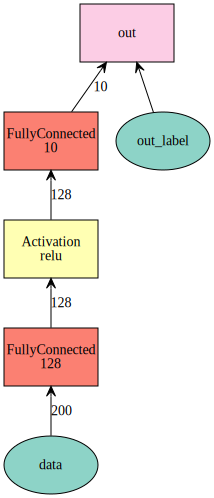

In [3]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net, shape={'data':(100, 200)})

In [4]:
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']

In [5]:
net = mx.symbol.Variable('data')
w = mx.symbol.Variable('myweight')
net = mx.symbol.FullyConnected(data=net, weight=w, name='fc1', num_hidden=128)
net.list_arguments()

['data', 'myweight', 'fc1_bias']

In [6]:
lhs = mx.symbol.Variable('data1')
rhs = mx.sym.Variable('data2')
net = mx.sym.FullyConnected(data=lhs+rhs, name='fc1', num_hidden=128)
net.list_arguments()

['data1', 'data2', 'fc1_weight', 'fc1_bias']

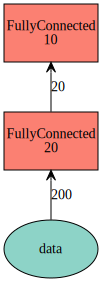

In [13]:
data = mx.symbol.Variable('data')
net1 = mx.symbol.FullyConnected(data=data, name='fc1', num_hidden=20)
net1.list_arguments()
net2 = mx.symbol.Variable('data2')
net2 = mx.symbol.FullyConnected(data=net2, name='fc2', num_hidden=10)
composed = net2(data2=net1, name='composed')
composed.list_arguments()
mx.viz.plot_network(composed, shape={'data':(100,200)})

In [16]:
data = mx.sym.Variable('data')
net = data
n_layer = 2
for i in range(n_layer):
    with mx.name.Prefix('layer%d_' % (i+1)):
        net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=100)
net.list_arguments()

['data',
 'layer1_fc1_weight',
 'layer1_fc1_bias',
 'layer2_fc1_weight',
 'layer2_fc1_bias']

### Construct the Google Inception network

In [18]:
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0,0), name=None, suffix=''):
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad, name='conv_%s%s' %(name, suffix))
    bn = mx.sym.BatchNorm(data=conv, name='bn_%s%s' %(name, suffix))
    act = mx.sym.Activation(data=bn, act_type='relu', name='relu_%s%s' %(name, suffix))
    return act

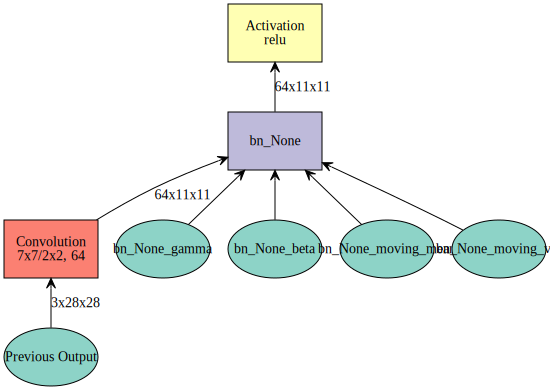

In [21]:
prev = mx.sym.Variable(name="Previous Output")
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7,7), stride=(2, 2))
shape = {"Previous Output" : (128, 3, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape)

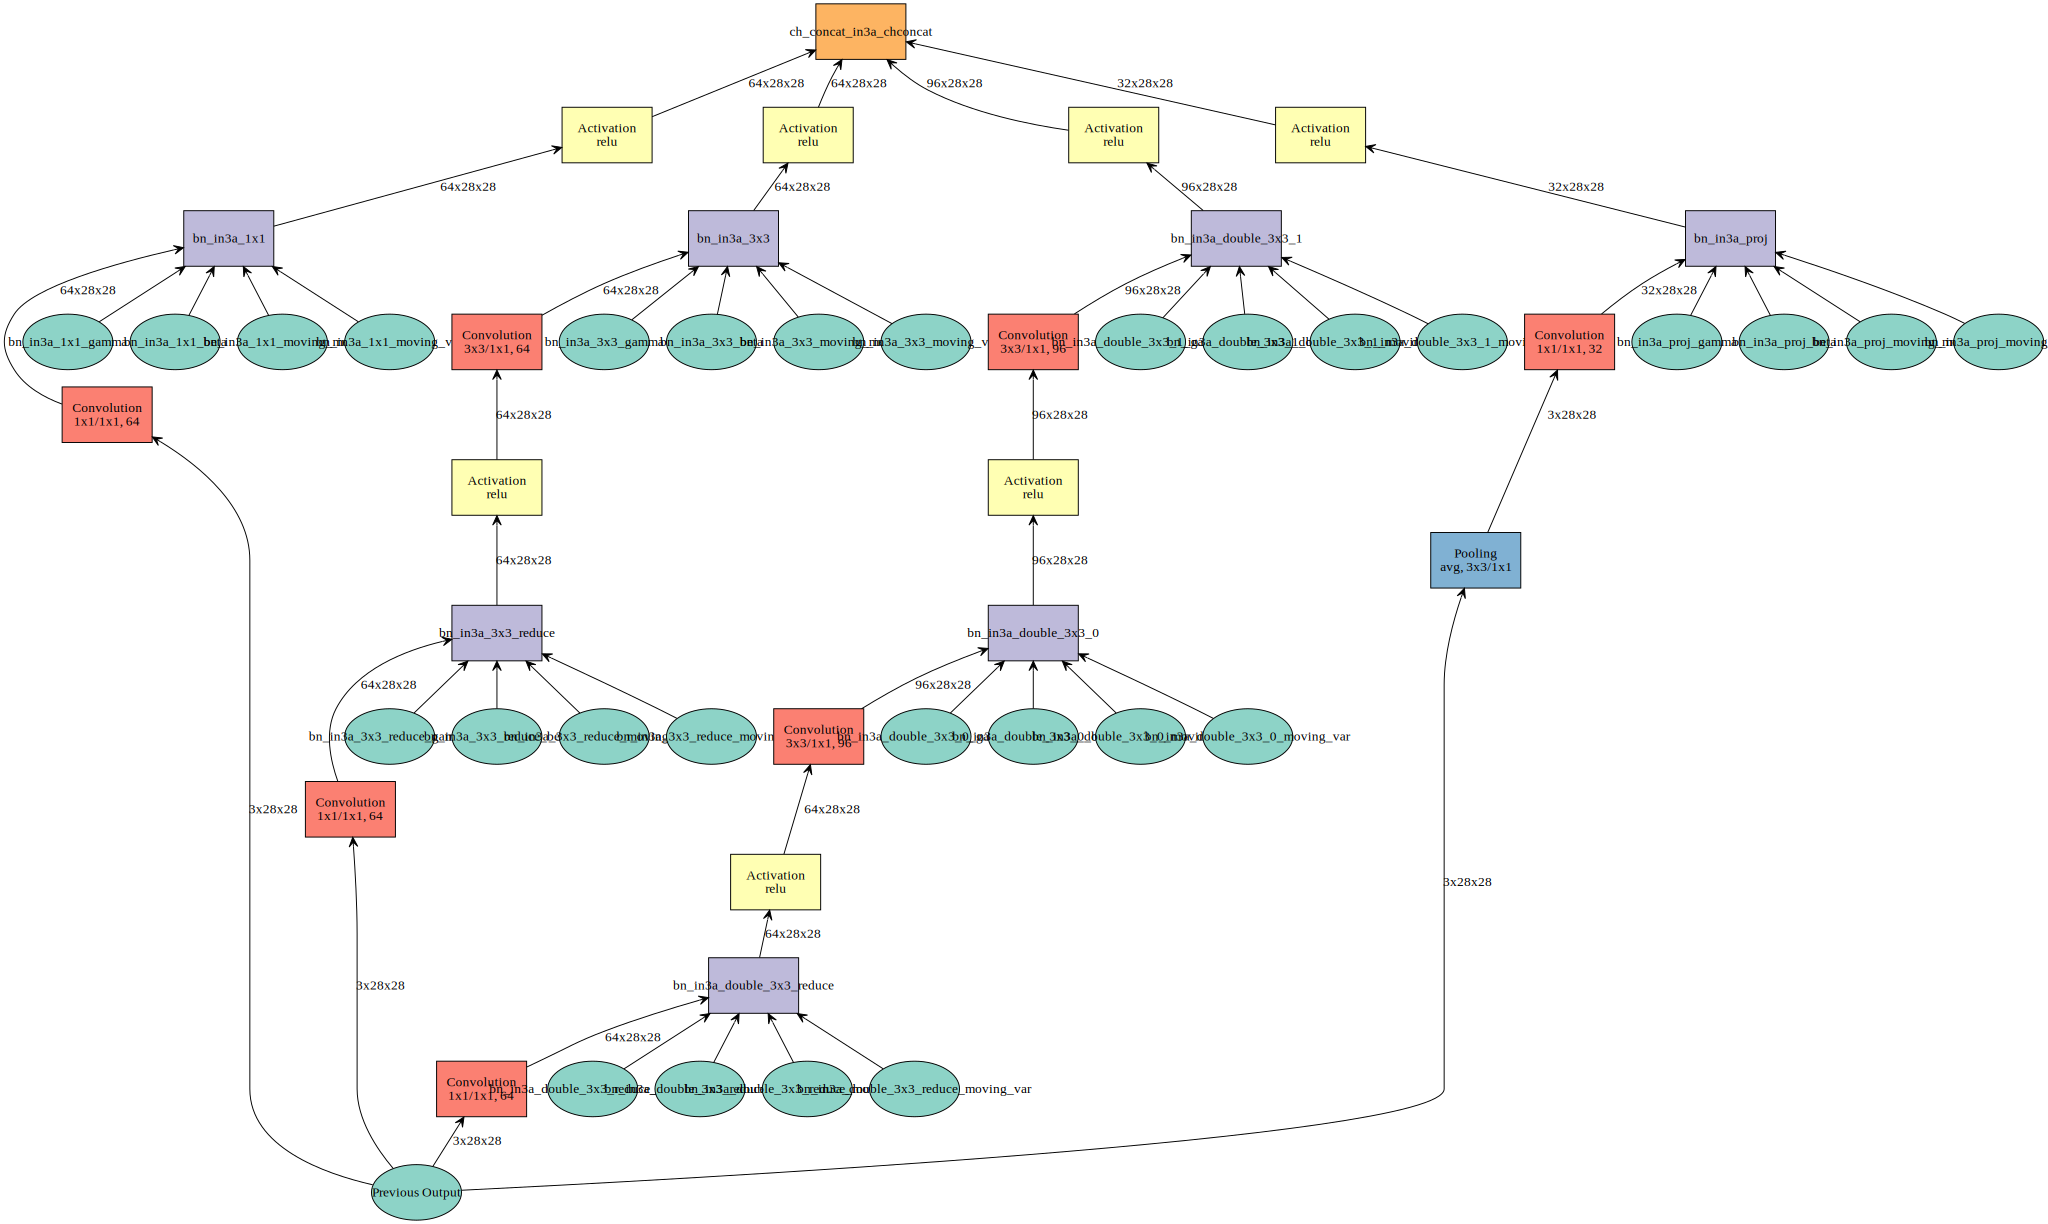

In [22]:
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red, num_d3x3,
                      pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1), name=('%s_1x1' % name))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1), name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), name=('%s_3x3' % name))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1), name=('%s_double_3x3' % name), suffix='_reduce')
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_0' % name))
    cd3x3 = ConvFactory(data=cd3x3, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_1' % name))
    # pool + proj
    pooling = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1), name=('%s_proj' %  name))
    # concat
    concat = mx.sym.Concat(*[c1x1, c3x3, cd3x3, cproj], name='ch_concat_%s_chconcat' % name)
    return concat
prev = mx.sym.Variable(name="Previous Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32, name="in3a")
mx.viz.plot_network(symbol=in3a, shape=shape)


In [23]:
net = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")
out1 = mx.sym.SoftmaxOutput(data=net, name='softmax')
out2 = mx.sym.LinearRegressionOutput(data=net, name='regression')
group = mx.sym.Group([out1, out2])
group.list_outputs()

['softmax_output', 'regression_output']

### Symbol Manipulation
most of them are wrapped by the module `package`

In [27]:
arg_name = c.list_arguments()
out_name = c.list_outputs()
# infers output shape given the shape of input arguments
arg_shape, out_shape, _ = c.infer_shape(a=(2,3), b=(2,3))
arg_type, out_type, _ = c.infer_type(a='float32', b='float32')
{
    'input' : dict(zip(arg_name, arg_shape)),
    'output' : dict(zip(out_name, out_shape))
}
{
    'input' : dict(zip(arg_name, arg_type)),
    'output' : dict(zip(out_name, out_type))
}

infer_shape error. Arguments:
  a: (2, 3)
  b: (2, 3)


MXNetError: [16:01:26] src/c_api/c_api_symbolic.cc:398: InferShapeKeyword argument name b not found.
Candidate arguments:
	[0]data
	[1]fc1_weight
	[2]fc1_bias
	[3]softmax_label
	[4]regression_label


Stack trace returned 4 entries:
[bt] (0) 0   libmxnet.so                         0x000000010dd512b5 _ZN4dmlc15LogMessageFatalD2Ev + 37
[bt] (1) 1   libmxnet.so                         0x000000010e34e97f _ZN5mxnet14MatchArgumentsIN4nnvm6TShapeEEEvRKNS1_12IndexedGraphERKNSt3__113unordered_mapINS6_12basic_stringIcNS6_11char_traitsIcEENS6_9allocatorIcEEEET_NS6_4hashISD_EENS6_8equal_toISD_EENSB_INS6_4pairIKSD_SE_EEEEEEPNS6_6vectorISE_NSB_ISE_EEEEPKc + 3519
[bt] (2) 2   libmxnet.so                         0x000000010e34caf8 MXSymbolInferShape + 1448
[bt] (3) 3   _ctypes.so                          0x000000010763bf57 ffi_call_unix64 + 79


### Bind with Data and Evaluate
the bind method, which accepts device context and a dict mapping free variable names to NDArrays as arguments and returns an executor.
The executor provides forward method for evaluation and an attribute outputs to get all the results.

In [28]:
ex = c.bind(ctx=mx.cpu(), args={'a':mx.nd.ones([2,3]), 'b':mx.nd.ones([2,3])})
ex.forward()
print "number of outputs = %d\n the first output = \n%s" %(len(ex.outputs), ex.outputs[0].asnumpy())

ValueError: key `data` is missing in `args`

In [29]:
ex_gpu = c.bind(ctx=mx.gpu(), args={'a' : mx.nd.ones([3,4], mx.gpu())*2,
                                    'b' : mx.nd.ones([3,4], mx.gpu())*3})
ex_gpu.forward()
ex_gpu.outputs[0].asnumpy()

MXNetError: [16:11:47] src/c_api/c_api_ndarray.cc:390: Operator _ones cannot be run; requires at least one of FCompute<xpu>, NDArrayFunction, FCreateOperator be registered

Stack trace returned 4 entries:
[bt] (0) 0   libmxnet.so                         0x000000010dd512b5 _ZN4dmlc15LogMessageFatalD2Ev + 37
[bt] (1) 1   libmxnet.so                         0x000000010e33fc24 MXImperativeInvoke + 4020
[bt] (2) 2   _ctypes.so                          0x000000010763bf57 ffi_call_unix64 + 79
[bt] (3) 3   ???                                 0x00007fff590e7530 0x0 + 140734687507760


In [30]:
ex = c.eval(ctx=mx.cpu(), a = mx.nd.ones([2,3]), b=mx.nd.ones([2,3]))
print 'number of outputs = %d\nthe first output = \n%s' % (len(ex), ex[0].asnumpy())

ValueError: key `data` is missing in `args`

In [32]:
a = mx.sym.Variable('data')
b = mx.sym.cast(data=a, dtype='uint8')
arg, out, _ = b.infer_type(data='float16')
print({'input':arg, 'output':out})

c = mx.sym.cast(data=a, dtype='uint8')
arg, out, _ = c.infer_type(data='int32')
print({'input':arg, 'output':out})

{'input': [<type 'numpy.float16'>], 'output': [<type 'numpy.uint8'>]}
{'input': [<type 'numpy.int32'>], 'output': [<type 'numpy.uint8'>]}
